In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
df = pd.read_csv('Final_Train_Data.csv')

# unify column names if needed
df.columns = [c.strip() for c in df.columns]
if 'PV Output' in df.columns:
    df.rename(columns={'PV Output':'PV_Output'}, inplace=True)

# parse timestamp, drop bad rows
df['time'] = pd.to_datetime(df['time'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['time']).set_index('time').sort_index()

# ensure hourly index & fill gaps
df = df.resample('h').mean()
df['PV_Output'] = df['PV_Output'].interpolate(method='time')

print("Data range:", df.index.min(), "to", df.index.max())

Data range: 2019-01-01 00:00:00 to 2024-12-31 23:00:00


In [10]:
series = df['PV_Output'].values.reshape(-1,1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

In [11]:
SEQ_LEN = 24

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, 0])
        y.append(data[i+seq_len, 0])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

X_all, y_all = create_sequences(series_scaled, SEQ_LEN)
timestamps = df.index[SEQ_LEN:]  # aligns with y_all

In [12]:
mask_train = timestamps.year <= 2023
mask_test  = timestamps.year == 2024

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_test,  y_test  = X_all[mask_test],  y_all[mask_test]

print("Train samples:", X_train.shape[0])
print("Test 2024 samples:", X_test.shape[0])

Train samples: 43800
Test 2024 samples: 8784


In [13]:
model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(64, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0146 - mae: 0.0776 - val_loss: 0.0011 - val_mae: 0.0221
Epoch 2/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 9.7113e-04 - mae: 0.0207 - val_loss: 6.2497e-04 - val_mae: 0.0154
Epoch 3/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 5.5653e-04 - mae: 0.0156 - val_loss: 4.7476e-04 - val_mae: 0.0146
Epoch 4/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.3354e-04 - mae: 0.0133 - val_loss: 3.8524e-04 - val_mae: 0.0115
Epoch 5/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 4.2292e-04 - mae: 0.0129 - val_loss: 4.3045e-04 - val_mae: 0.0116
Epoch 6/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 3.9970e-04 - mae: 0.0125 - val_loss: 3.7855e-04 - val_mae: 0.0110
Epoch 7/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 3.8218e-04 - mae: 0.0120 - val_loss: 4.2009e-04 - val_mae: 0.0129
Epoch 8/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 3.8554e-04 - mae: 0.0121 - val_loss: 4.3719e-04 - v

In [15]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"2024 Test MSE: {mse:.4f}, MAE: {mae:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
2024 Test MSE: 0.0001, MAE: 0.0066


In [16]:
test_index = timestamps[mask_test]
df_results = pd.DataFrame({
    'datetime': test_index,
    'actual': y_true,
    'predicted': y_pred
})
df_results.set_index('datetime', inplace=True)
df_results

,actual,predicted
datetime,,
2024-01-01 00:00:00,0.0,0.001168
2024-01-01 01:00:00,0.0,0.001158
2024-01-01 02:00:00,0.0,0.001080
2024-01-01 03:00:00,0.0,0.000943
2024-01-01 04:00:00,0.0,0.000782
...,...,...
2024-12-31 19:00:00,0.0,0.001024
2024-12-31 20:00:00,0.0,0.001062
2024-12-31 21:00:00,0.0,0.001057


In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
def calculate_error_metrics(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mse = mean_squared_error(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)


    naive_forecast = np.roll(y_true, 1)[1:]
    naive_error = np.mean(np.abs(y_true[1:] - naive_forecast))
    mase = mae / naive_error if naive_error != 0 else np.inf

    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'MASE': mase
    }

In [25]:
metrics = calculate_error_metrics(df_results['actual'], df_results['predicted'])

print("Error Metrics for model RNN:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Error Metrics for model RNN:
MSE: 0.0001
MAE: 0.0066
MAPE: 26.4741
MASE: 0.2164


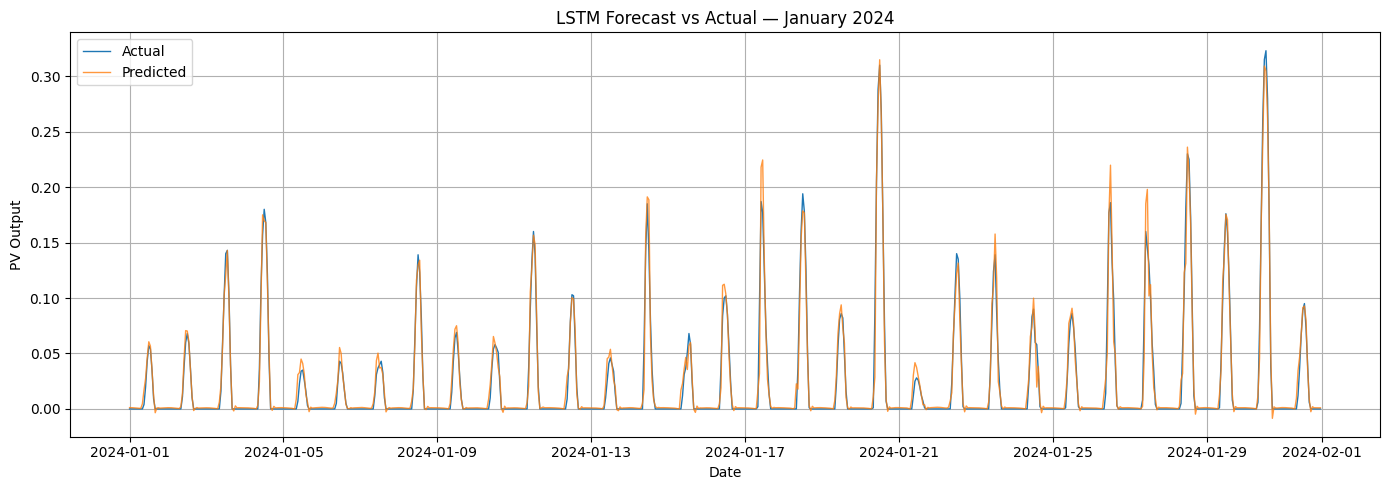

In [29]:
import calendar
jan = df_results[df_results.index.month == 1]

plt.figure(figsize=(14, 5))
plt.plot(jan.index, jan['actual'], label='Actual', linewidth=1)
plt.plot(jan.index, jan['predicted'], label='Predicted', alpha=0.8, linewidth=1)
plt.title('LSTM Forecast vs Actual — January 2024')
plt.xlabel('Date')
plt.ylabel('PV Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
df_daily = df_results.resample('D').sum(numeric_only=True)

,actual,predicted
datetime,,
2024-01-01,0.222,0.269153
2024-01-02,0.282,0.320244
2024-01-03,0.604,0.600681
2024-01-04,0.817,0.821384
2024-01-05,0.144,0.220606
...,...,...
2024-12-27,0.559,0.574489
2024-12-28,0.163,0.215247
2024-12-29,0.426,0.438821


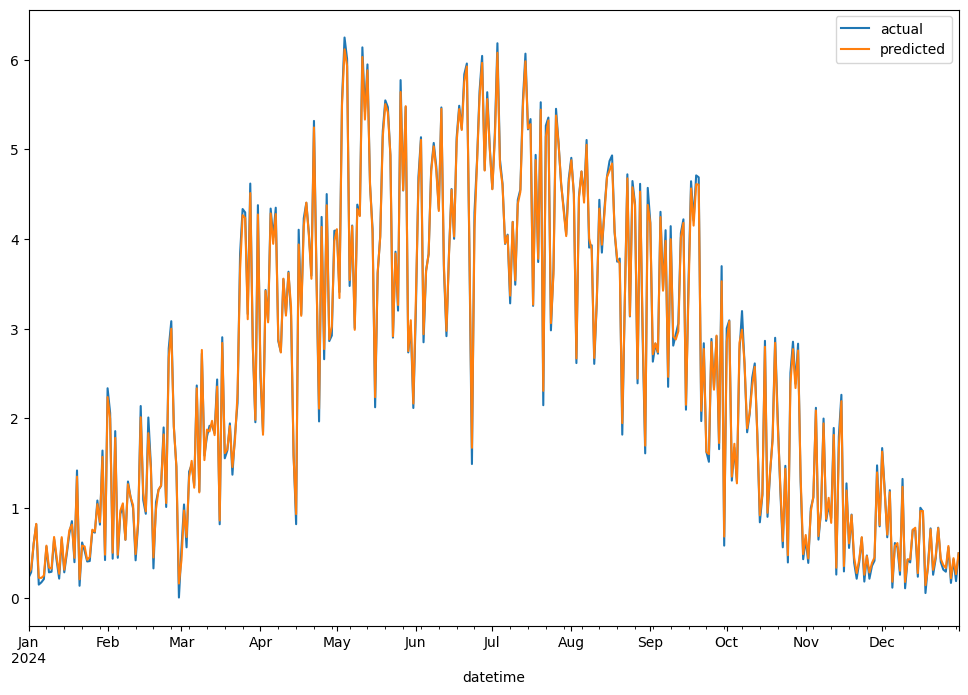

In [28]:
df_daily[['actual','predicted']].plot(figsize=(12,8))
df_daily

In [18]:
output_filename = 'Actual_Forecast_Data.xlsx'
df_results.to_excel(output_filename, index=True)

# 3. Trigger download to your local computer
from google.colab import files
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

import os
save_dir = '/content/drive/MyDrive/models'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'lstm_model.keras')
model.save(save_path)
print("Saved to", save_path)


Mounted at /content/drive
Saved to /content/drive/MyDrive/models/lstm_model.keras


In [20]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow import keras
load_path = '/content/drive/MyDrive/models/lstm_model.keras'
model = keras.models.load_model(load_path)
print("Model loaded successfully")
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,924 (132.52 KB)